# Overview

This tutorial will show you how to:
  1. Train BPNet
  2. Compute contribution scores
  3. Discover motifs with TF-MoDISco
  4. Determine motif instances with CWM scanning
  5. Simulate motif spacing
  

This will be done on a subset of the data from the [BPNet paper](https://www.biorxiv.org/content/biorxiv/early/2019/08/21/737981.full.pdf) measuring TF binding of 3/4 TFs (Oct4, Sox2, and Nanog) with ChIP-nexus in mouse embryonic stem cells (mESCs). To make things faster, we will only use peak regions from chromosomes 2, 16, 17, 18 and 19 to train/evaluate the model and run TF-MoDISco (**10% of the original data**).

We'll be using the `bpnet` python package to accomplish these steps. You can find out more about it at https://github.com/kundajelab/bpnet.

Use the 'Table of contents' on the left to navigate this notebook. If you have any suggestions or questions, you can add comments to the individual cells using the Ctrl+Alt+M shortcut.




## Setup

Make sure you have enabled the GPU runtime by navigating to the menu 'Runtime', select 'Change runtime type' and set the runtime to 'GPU'.

### Install dependencies

In [2]:
!pip install tensorflow==1.7.0

!apt-get install -y bedtools > /dev/null
!pip install git+https://github.com/kundajelab/DeepExplain.git --quiet
!pip install -U cloudpickle h5py tqdm --quiet
!pip install -U pyyaml --quiet
!pip install bpnet --quiet --quiet
!pip install -U jupyter_client>=6.1.2 --quiet
!pip install wandb snakemake --quiet
!pip install h5py==2.10.0

%env HDF5_USE_FILE_LOCKING=FALSE

# NOTE: after running this, restart the runtime: Runtime -> Restart runtime -> yes

E: ロックファイル /var/lib/dpkg/lock-frontend をオープンできません - open (13: 許可がありません)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
env: HDF5_USE_FILE_LOCKING=FALSE


If you are running this on your own machine, please see the installation intructions at https://github.com/kundajelab/bpnet.

In [3]:
import bpnet
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg

import uuid
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import numpy as np

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

### Get test data

In [4]:
# Dowload and extract the bpnet repo
!wget 'https://drive.google.com/uc?authuser=0&id=1YX1svzlRnLtvxyzj5O4B1l5-_wArZ9Q6&export=download' -O bpnet.tar.gz
!tar xvfz bpnet.tar.gz  > /dev/null

--2024-04-24 17:52:24--  https://drive.google.com/uc?authuser=0&id=1YX1svzlRnLtvxyzj5O4B1l5-_wArZ9Q6&export=download
drive.google.com (drive.google.com) をDNSに問いあわせています... 142.250.76.142, 2404:6800:400a:80e::200e
drive.google.com (drive.google.com)|142.250.76.142|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 303 See Other
場所: https://drive.usercontent.google.com/download?id=1YX1svzlRnLtvxyzj5O4B1l5-_wArZ9Q6&export=download [続く]
--2024-04-24 17:52:25--  https://drive.usercontent.google.com/download?id=1YX1svzlRnLtvxyzj5O4B1l5-_wArZ9Q6&export=download
drive.usercontent.google.com (drive.usercontent.google.com) をDNSに問いあわせています... 142.250.206.193, 2404:6800:400a:813::2001
drive.usercontent.google.com (drive.usercontent.google.com)|142.250.206.193|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 9991174 (9.5M) [application/octet-stream]
`bpnet.tar.gz' に保存中

bpnet.tar.gz        100%[===================>]   9.53M  7.62MB/s    in 1.3s    

2024-04-24 17:52:30 (7.6

In [5]:
# Download chip_nexus data
!sh ~/bpnet/examples/chip-nexus/get_bed.sh

--2024-04-24 17:52:31--  http://mitra.stanford.edu/kundaje/avsec/chipnexus/paper/data/mm10.subset.fa.gz
mitra.stanford.edu (mitra.stanford.edu) をDNSに問いあわせています... 171.67.96.243
mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://mitra.stanford.edu/kundaje/avsec/chipnexus/paper/data/mm10.subset.fa.gz [続く]
--2024-04-24 17:52:32--  https://mitra.stanford.edu/kundaje/avsec/chipnexus/paper/data/mm10.subset.fa.gz
mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 154829118 (148M) [application/x-gzip]
`examples/data/mm10.subset.fa.gz' に保存中

examples/data/mm10. 100%[===================>] 147.66M  23.2MB/s    in 7.2s    

2024-04-24 17:52:40 (20.4 MB/s) - `examples/data/mm10.subset.fa.gz' へ保存完了 [154829118/154829118]

gzip: examples/data/mm10.subset.fa already exists; do you wish to overwrite (y or n)? ^C


# Train BPNet

<img src="https://github.com/kundajelab/bpnet/blob/master/notebooks/figs/bpnet-arch.png?raw=1" alt="BPNet" style="width: 450px;"/>

## 1. Specify data -> write `dataspec.yml`

BPNet takes as input nucleotide sequence and outputs the read coverage profile for multiple tracks at base-resolution. The coverage tracks can come from any genome-wide functional genomics assay that has a sufficient spatial resolution including ChIP-nexus, ChIP-exo, ChIP-seq, DNase-seq, and ATAC-seq. Additionally, different experiments may have differnet biases that need to be accounted for using the control or bias experiments. Both, the signal and the bias/control tracks have to be stored in [BigWig](https://genome.ucsc.edu/goldenpath/help/bigWig.html) files.


The file paths to the BigWig tracks on which to train the model should be specified in a `dataspec.yml` as follows:

In [6]:
from pathlib import Path
exp_dir = Path('~/bpnet/examples/chip-nexus/')

!cat {exp_dir}/dataspec.yml

fasta_file: ../data/mm10.subset.fa  # reference genome fasta file
task_specs:  # specifies multiple tasks (e.g. Oct4, Sox2 Nanog)

  Oct4:
    tracks:
      - ../data/chip-nexus/Oct4/counts.pos.subset.bw
      - ../data/chip-nexus/Oct4/counts.neg.subset.bw
    peaks: ../data/chip-nexus/Oct4/idr-optimal-set.summit.subset.bed.gz
  Sox2:
    tracks:
      - ../data/chip-nexus/Sox2/counts.pos.subset.bw
      - ../data/chip-nexus/Sox2/counts.neg.subset.bw
    peaks: ../data/chip-nexus/Sox2/idr-optimal-set.summit.subset.bed.gz

  Nanog: # Nanog is the task name
    tracks:
      # List of bigwig files (1 or more) corresponding to the task
      # The model will predict each track individually (here coverage of
      # reads mapping to the positive and negative strand) and
      # the contribution scores will be averaged across all of these tracks
      - ../data/chip-nexus/Nanog/counts.pos.subset.bw
      - ../data/chip-nexus/Nanog/counts.neg.subset.bw

    # Peaks associated with Nanog task

### Data stats

In [7]:
# chromsomome names of differnet peaks
!zcat ~/bpnet/examples/data/chip-nexus/*/idr-optimal-set.summit.subset.bed.gz | cut -f 1 | sort -u

chr16
chr17
chr18
chr19
chr2


Each task (or TF) can specify a set of peaks associated with it. Here are the number of peaks per TF we will use in this tutorial:

In [8]:
tasks = ['Oct4', 'Sox2', 'Nanog']

# number of peaks per task
for task in tasks:
  print(task)
  !zcat ~/bpnet/examples/data/chip-nexus/{task}/idr-optimal-set.summit.subset.bed.gz | wc -l

Oct4
5373


Sox2
2265
Nanog
12007


### FAQ

#### How can I visualize the raw data before training the model?

Glad you asked. Before you jump ahead and start training the model, we recommend eyeballing the coverage tracks (BigWig) and peak regions (bed) using the genome browser such as the [WashU](https://epigenomegateway.wustl.edu/) or [IGV](https://software.broadinstitute.org/software/igv/). If you can not identify peaks by eye then the model will not be able to do it either.

Having specified your data in `dataspec.yml`, you can use also `bpnet.specs.DataSpec` to parse the file and visualize the tracks for a specific genomic interval in your jupyter notebook.

#### How do I get my data into a BigWig file?

Functional genomics experiments based on sequencing yield many short reads which then get aligned to the reference genome. The alignment locations of the reads are typically stored in the [BAM](http://samtools.github.io/hts-specs/SAMv1.pdf) file. There are different ways of computing the coverage tracks from aligned reads. To prevent loosing any spatial information in the profiles, we would like to generate non-smoothed tracks (as raw as possible). For ChIP-exo/nexus/seq experiments this means counting the 5' locations of the reads. Note that the aligned reads also have strand information hence you should generate two coverage tracks, one for the positive/forward and one for the negative/reverse strand. If multiple technical or biological replicate experiments were performed for a specific transcription factor, we recommend to add up their coverage (for example by merging the BAM files or adding the coverage tracks of the BigWig files).

Here are the commands to do the conversion from BAM to BigWig for both strands:

1. Sort the bam file: `samtools sort alignments.pos.bam alignments.sorted.bam`
2. Convert BAM to bedGraph for positive and strand:
```
bedtools genomecov -5 -bg -strand + -ibam alignments.sorted.bam | sort -k1,1 -k2,2n > alignments.pos.bedGraph
bedtools genomecov -5 -bg -strand - -ibam alignments.sorted.bam | sort -k1,1 -k2,2n > alignments.neg.bedGraph
```
3. Convert begGraph to bigwig using bedGraphToBigWig from UCSC ([download link](http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedGraphToBigWig)):
```
bedGraphToBigWig alignments.pos.bedGraph genome.chromosome-sizes.txt alignments.pos.bw
bedGraphToBigWig alignments.neg.bedGraph genome.chromosome-sizes.txt alignments.neg.bw
```

`genome.chromosome-sizes.txt` is the genome file containing `chromosome_name<TAB>chromosome_length` entries.

See also the [Snakemake rules](https://github.com/kundajelab/bpnet-manuscript/blob/d7af1bda3ac8cc342b32f9cdac481ba55fe7ddca/src/bpnet-pipeline/prepare-data.smk#L99-L133) for conversion from TagAlign files instead of BAM files and the [ChIP-nexus pipeline](https://github.com/kundajelab/chip-nexus-pipeline/blob/ea40683d65b9317843a7fbdcc75bd33e481bee8e/src/encode_count_signal_track.py#L29-L60).


#### How do I get `regions.bed`?

For large genomes such as human or mouse, training genome-wide can be computationally expensive. Most of the regions in the genome will contain very little counts, hence the model will not recieve a lot of information. We can significantly speed up the training process by training the model only in regions with higher number of counts. These regions are determined using traditional peak callers such as MACS2. Since we just want to discard regions with little or no counts, we don't care about the exact peak locations or even high false positive rates. Hence almost any peak caller should be fine.

#### Can I train the model without the bias track?

Technically, yes. It will work well for assays with low amount of bias such as ChIP-exo or ChIP-nexus. However, we generally recommend using the bias track.

#### Can I train the model with differnet assays simultaneusly?

Yes. If you are using different assays with similar resolution (e.g. ChIP-nexus and ChIP-exo), you can just specify the bigwig files and use different bias/control files for differnt subsets of the tracks. If you are using different assays with different resolutions, you might want to tweak the parameters of model output heads to best fit the individual experiments.

#### Should I train a single multi-task model or multiple single-task models?

If you expect the tracks to share some sequence motifs, it's likely beneficial to train a multi-task model (e.g. use a single `dataspec.yml`). Also, handling a single model is more convenient than handling multiple models. However, if you have many tracks it might be challenging to train a multi-task model.

## 2. Train the model

Having specified `dataspec.yml`, we are now ready to train the model with

```
bpnet train <dataspec.yml> <output dir> [optional flags]`
```


We will use a pre-made model [bpnet9](../bpnet/premade/bpnet9.gin) as a starting point and modify a few parameters specified in the config.gin file. Specifically, we will
- train the model only on chromosomes 16-19
- evaluate the model on chromosome 2
- use only 3 layers of dilated convolutions
- use an input sequence length of 200 bp and accordingly lower the augmentation shift to 100 bp

In [9]:
!cat {exp_dir}/config.gin
# NOTE: test_chr will be also excluded similar to 'exclude_chr'

# exclude a large portion of the training set
exclude_chr=["chrX","chrY","chr5","chr6","chr7","chr10","chr14","chr11","chr13","chr12","chr15"]
valid_chr = ['chr2']
test_chr = ['chr1', 'chr8', 'chr9',
            'chr3', 'chr4']
seq_width = 200
n_dil_layers = 3
bpnet_data.interval_augmentation_shift = 100
train.seed = 1


Have a look at the original gin file of bpnet9 here: https://github.com/kundajelab/bpnet/blob/master/bpnet/premade/bpnet9-ginspec.gin. For more information on using gin files see <https://github.com/google/gin-config>.

To track model training and evaluation, we will use [wandb](http://wandb.com/) by adding `--wandb=avsec/bpnet-demo` to `bpnet train`. You can navigate to https://app.wandb.ai/avsec/bpnet-demo to see the training progress.

Let's train!

In [10]:
# setup a new run_id (could be done automatically, but then the output directory would change)
run_id = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "_" + str(uuid.uuid4())

# Train for at most 10 epochs
!cd {exp_dir} && bpnet train dataspec.yml --premade=bpnet9 --config=config.gin . --override='train.epochs=20' --run-id '{run_id}' --in-memory

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [11]:
# setup all the file paths
import os
model_dir = os.path.join(exp_dir, run_id)

# create link to avoid possible errors from wrong long dir names
!rm -rf "/home/dahale.onkar/bpnet/examples/chip-nexus/output/"
!mkdir "/home/dahale.onkar/bpnet/examples/chip-nexus/output/"
!ln -s {model_dir} "/home/dahale.onkar/bpnet/examples/chip-nexus/output/"
output_dir = exp_dir / 'output'
contrib_file = "/home/dahale.onkar/bpnet/examples/chip-nexus/output/contrib.deeplift.h5"
contrib_null_file = "/home/dahale.onkar/bpnet/examples/chip-nexus/output/contrib.deeplift.null.h5"
modisco_dir = "/home/dahale.onkar/bpnet/examples/chip-nexus/output/modisco"

In [12]:
# To see `bpnet train` docs run the following cell
!bpnet train -h

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

### View the evaluation results

`bpnet train` produces the following output files:

In [13]:
!ls -latr {model_dir}/

合計 6888
drwxr-xr-x 2 dahale.onkar mib-dbia    4096  4月 24 17:55 log
-rw-r--r-- 1 dahale.onkar mib-dbia       2  4月 24 17:55 note_params.json
-rw-r--r-- 1 dahale.onkar mib-dbia     451  4月 24 17:55 bpnet-train.kwargs.json
-rw-r--r-- 1 dahale.onkar mib-dbia     321  4月 24 17:55 input-config.gin
-rw-r--r-- 1 dahale.onkar mib-dbia    1213  4月 24 17:55 dataspec.yml
-rw-r--r-- 1 dahale.onkar mib-dbia    6148  4月 24 17:55 config.gin
-rw-r--r-- 1 dahale.onkar mib-dbia    4271  4月 24 17:55 config.gin.json
-rw-r--r-- 1 dahale.onkar mib-dbia    5006  4月 24 17:59 history.csv
-rw-r--r-- 1 dahale.onkar mib-dbia 1181685  4月 24 17:59 events.out.tfevents.1713948948.mib-private-gw01
-rw-r--r-- 1 dahale.onkar mib-dbia  797928  4月 24 17:59 model.h5
-rw-r--r-- 1 dahale.onkar mib-dbia  998099  4月 24 17:59 seq_model.pkl
-rw-r--r-- 1 dahale.onkar mib-dbia    6663  4月 24 18:00 evaluation.valid.json
-rw-r--r-- 1 dahale.onkar mib-dbia 1711313  4月 24 18:00 evaluate.ipynb
drwxr-xr-x 3 dahale.onkar mib-dbia    4096

The main output files are:

- model.h5 - Keras model HDF5 file
- seq_model.pkl - Serialized SeqModel. This is the main trained model.
- eval-report.ipynb/.html - evaluation report containing training loss curves and some example model predictions.
- model.gin -> copied from the input
- dataspec.yaml -> copied from the input

In [15]:
#bpnet/examples/chip-nexus/2024-04-23_17-58-43_bbc70908-74e9-4bbd-9a13-983dc873e318/evaluate.html
out_dir  = os.path.join(exp_dir, "output")
test = "bpnet/examples/chip-nexus/2024-04-23_17-58-43_bbc70908-74e9-4bbd-9a13-983dc873e318/evaluate.html"

HTML(test)

## 3. Tweak the model

### Modify the hyper-parameters

The first step you can do to improve your model is to adapt the hyper-parameters of the existing model. Have a look at the default hyper-parameters of the pre-made model you were using here: [../bpnet/premade/bpnet9.gin](../bpnet/premade/bpnet9.gin). You can directly override the hyper-parameters from the command line as follows:

```bash
bpnet train dataspec.yaml --premade=bpnet9 --override='train.lr=0.05;model.multi_task_model.n_layers=5' -o trained_model/
```

This will use a different learning rate (0.05) and less convolutional layers (5) by overriding the original values. Note that multiple parameter specifications were separated using `;`. If you find it impractical to specify the hyper-parameters from the CLI, you can instead specify them in the `model.gin` config file:

```python
train.lr = 0.05
model.multi_task_model.n_layers = 5
```

and then run `bpnet train` as follows:

```bash
bpnet train dataspec.yaml --premade=bpnet9 --config=model.gin -o trained_model/
```

Note that you can use `--override` and `--config` simultaneusly. If both specify the same parameter, then the one specified by `--override` will be used. For example, the following command will use the learning rate of 0.01.

```bash
bpnet train dataspec.yaml --premade=bpnet9 --config=model.gin --override='train.lr=0.01' -o trained_model/
```

Altogether, `--config` overrides the parameters specified by `--premade`; `--override` overrides parameters specified by `--config` and `--premade` (e.g. `--override` > `--config` > `--premade`).

### Specify your own model architecture, loss function or training procedure

Have a look at the [gin-config documentation](https://github.com/google/gin-config) to learn more about the gin config files. This will help you understand how you can utilize them effectively and thereby go beyond the premade models. To specify your own architecture, use a different loss function or a different training procedure, you have to do three things:
1. Implement a python function returning the `bpnet.seqmodel.SeqModel` object.
2. Decorate the function with `@gin.configurable`
3. Specify that you would like to use this model in the `model.gin` config file.

#### How do I specify my own jupyter notebook for evaluation?

You can specify your own jupyter notebook by specifying the `train.eval_report='<path>.ipynb'` in either `config.gin` file or by specifying `--override='train.eval_report="<path>.ipynb"'`. Make sure to copy the first cell of https://github.com/kundajelab/bpnet/blob/master/bpnet/templates/evaluate.ipynb to your template notebook as it contains the following cell metadata: `{"tags": ["parameters"]}`. See https://github.com/nteract/papermill#parameterizing-a-notebook on how to set this yourself.

#### What is `bpnet.seqmodel.SeqModel`?

`SeqModel` is a wrapper around the Keras model. It requires the input to be a one-hot-encoded DNA sequence and it consists of two key components: body and heads. Body will process the input sequence with multiple layers yielding the bottleneck activation map which can be seens as containing an embedding at each nucleotide position. Heads will take the bottleneck activation map as input and they will output the final model predictions. Heads specify the loss function and the evaluation metric. They can additionally accept the bias/control track as input and control for it in the loss function. The benefit of restricting the model architecture in that way is that the sequence contribution scores can be automatically computed with no extra code. Have a look at the `SeqModel` [source code](../bpnet/seqmodel.py) to learn more about it.

# Compute contribution scores

In [16]:
# contribution scores
!bpnet contrib {model_dir} --method=deeplift --memfrac-gpu=1 --contrib-wildcard='*/profile/wn' {contrib_file} --overwrite

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

In [17]:
# null contribution scores obtained by shuffling the sequences.
!bpnet contrib {model_dir}  --method=deeplift --memfrac-gpu=1 --shuffle-seq --max-regions 5000 --contrib-wildcard='*/profile/wn' {contrib_null_file} --overwrite

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

In [18]:
# To see `bpnet contrib` docs run the following cell
!bpnet contrib -h

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

### Visualize the contribution scores

Previous command generates an HDF5 file `contrib_file` containing the contribution scores. You can access the the values stored in this file by using the `ContribFile` class.

In [19]:
import seaborn as sns
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg
import seaborn as sns
import matplotlib.pyplot as plt

cf = ContribFile(contrib_file)

In [20]:
# get chip-nexus profiles and contribution scores from the ContribFile
profiles = cf.get_profiles()
contrib_scores = cf.get_contrib()

In [21]:
# get example idx with most chip-nexus counts for each task
examples = list({v.max(axis=-2).mean(axis=-1).argmax() for k,v in profiles.items()})
examples

[1, 261, 9]

In [22]:
tasks = ['Oct4', 'Sox2', 'Nanog']

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


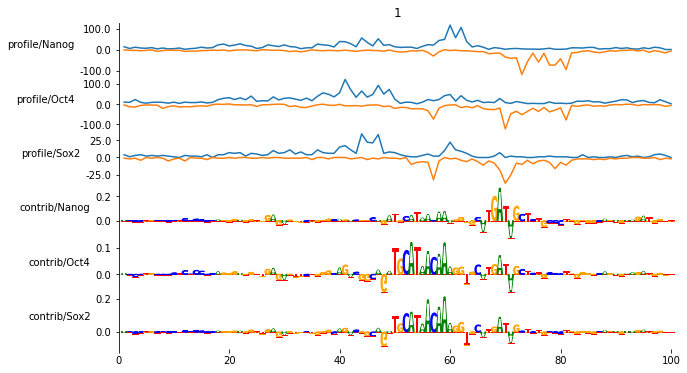

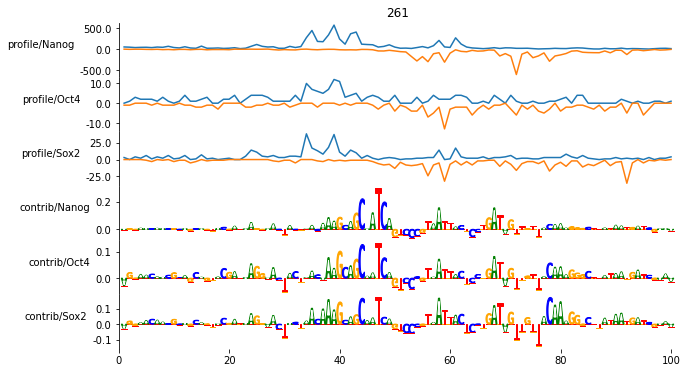

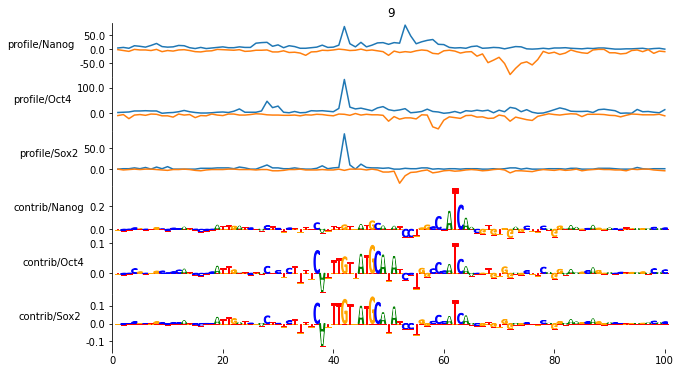

In [23]:
xrange = slice(50, 150)
for idx in examples:
  plot_tracks({**{'profile/' + k: to_neg(v[idx,xrange]) for k,v in profiles.items()},
               **{'contrib/' + k:v[idx,xrange] for k,v in contrib_scores.items()}},
             title=idx,
             rotate_y=0,
             fig_width=10,
             fig_height_per_track=1);
  sns.despine(top=True, right=True, bottom=True)

Have a look at the [ContribFile API](https://github.com/kundajelab/bpnet/blob/0cb7277b736260f8b4084c9b0c5bd62b9edb5266/bpnet/cli/contrib.py#L262) to explore all the available methods.

 ## Export BigWig files containing contribution scores and model predictions

In [24]:
!bpnet export-bw {model_dir} {model_dir}/bigwigs/ --contrib-method=deeplift --scale-contribution
# scale-contribution will multiply the contribution scores with total count predictions
# this will ensure that regions without high counts won't get high contribution scores
# We generally recommend using --scale-contribution

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

In [25]:
!ls -latr {model_dir}/bigwigs/

合計 228060
drwxr-xr-x 4 dahale.onkar mib-dbia     4096  4月 24 18:04 ..
drwxr-xr-x 2 dahale.onkar mib-dbia     4096  4月 24 18:04 log
drwxr-xr-x 3 dahale.onkar mib-dbia     4096  4月 24 18:08 .
-rw-r--r-- 1 dahale.onkar mib-dbia 19167900  4月 24 18:09 Oct4.preds.pos.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19182608  4月 24 18:09 Oct4.preds.neg.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19754438  4月 24 18:09 Oct4.contrib.profile.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19668784  4月 24 18:09 Oct4.contrib.counts.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19161723  4月 24 18:09 Sox2.preds.pos.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19166972  4月 24 18:09 Sox2.preds.neg.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19793749  4月 24 18:09 Sox2.contrib.profile.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19625243  4月 24 18:09 Sox2.contrib.counts.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19243181  4月 24 18:09 Nanog.preds.pos.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 19236338  4月 24 18:09 Nanog.preds.neg.bw
-rw-r--r-- 1 dahale.onkar mib-dbia 1

You  could visualize these files in the genome browser.

# Run TF-MoDISco to discover motifs

Next step is to cluster the contribution scores into motifs using TF-MoDISco. At first, we will cluster the Oct4 contribution scores in Oct4 peaks (`--only-task-regions`).

In [26]:
task = 'Oct4'

In [30]:
# Run modisco only for the Oct4 task
!bpnet modisco-run {contrib_file} --null-contrib-file={contrib_null_file} --contrib-wildcard={task}/profile/wn --premade=modisco-50k --override='TfModiscoWorkflow.min_metacluster_size=1000' --only-task-regions {modisco_dir}/{task}/ --overwrite

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/


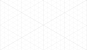
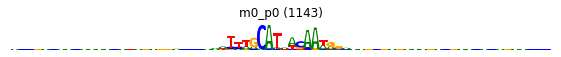
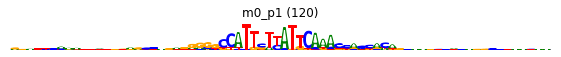
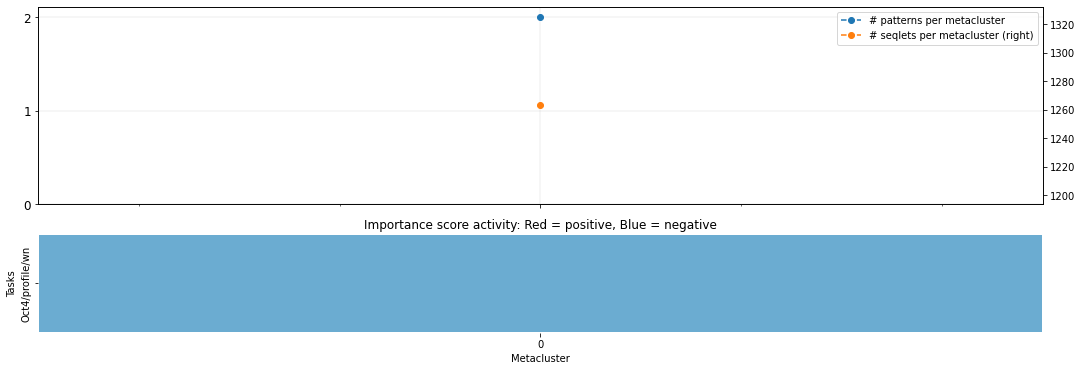
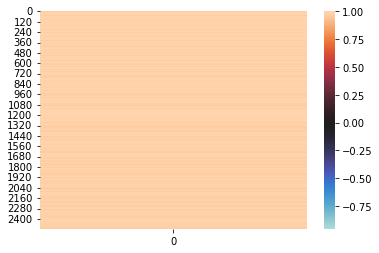

In [31]:
# View the modisco results
HTML(filename=Path(modisco_dir) / 'Oct4/modisco.html')

## Visualizing modisco results

Here is an example how you can access the `modisco.h5` file in python and visualize the results yourself.

In [33]:
# Modisco generated the following files for each TF
!ls -latrh {modisco_dir}/{task}

合計 17M
drwxr-xr-x 2 dahale.onkar mib-dbia 4.0K  4月 24 18:10 log
drwxr-xr-x 3 dahale.onkar mib-dbia 4.0K  4月 24 18:10 ..
-rw-r--r-- 1 dahale.onkar mib-dbia  656  4月 24 18:10 modisco-run.kwargs.json
-rw-r--r-- 1 dahale.onkar mib-dbia  186  4月 24 18:10 modisco-run.config.gin
-rw-r--r-- 1 dahale.onkar mib-dbia    4  4月 24 18:10 modisco-run.config.gin.json
-rw-r--r-- 1 dahale.onkar mib-dbia  20K  4月 24 18:10 modisco-run.subset-contrib-file.npy
-rw-r--r-- 1 dahale.onkar mib-dbia  16M  4月 24 18:13 modisco.h5
-rw-r--r-- 1 dahale.onkar mib-dbia  69K  4月 24 18:13 modisco.ipynb
drwxr-xr-x 3 dahale.onkar mib-dbia 4.0K  4月 24 18:13 .
-rw-r--r-- 1 dahale.onkar mib-dbia 629K  4月 24 18:13 modisco.html


In [34]:
from bpnet.modisco.files import ModiscoFile, ModiscoFileGroup

/mnt/mib-nas03_1/users/dahale.onkar/bpnet/bpnet/plot/heatmaps.py:6: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


TF-MoDISco is using the TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


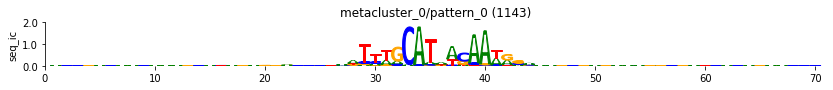

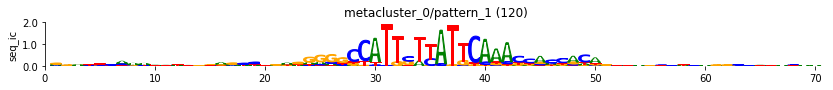

In [35]:
# Alternative way of loading the files
modisco_file = os.path.join(modisco_dir, 'Oct4/modisco.h5')
mf = ModiscoFile(modisco_file)

for p in mf.patterns():
  n_seqlets = mf.n_seqlets(p.name)
  p.plot("seq_ic", title=f"{p.name} ({n_seqlets})")
  plt.ylim([0, 2])
  sns.despine(top=True, bottom=True, right=True)

## Visualize the ChIP-nexus heatmaps

In [38]:
# load seqlets for the main motif
mf = ModiscoFile(Path(modisco_dir) /  'Oct4/modisco.h5')
seqlets = mf._get_seqlets('metacluster_0/pattern_0')

# load the ContribFile
# NOTE: we have to load it using `from_modisco_dir` since
# modisco was executed only on a subset of the
# regions present in ContribFile
cf = ContribFile.from_modisco_dir(Path(modisco_dir) / 'Oct4')

# extract into `StackedSeqletContrib`
sc = cf.extract(seqlets)

/mnt/mib-nas03_1/users/dahale.onkar/bpnet/bpnet/plot/heatmaps.py:40: RuntimeWarning: invalid value encountered in true_divide
  snorms = np.minimum(s / p99[:, np.newaxis], 1)


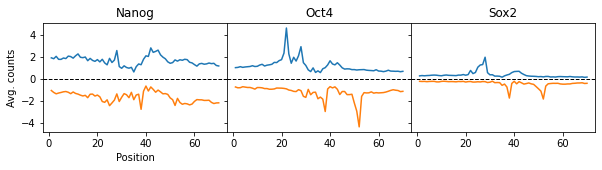

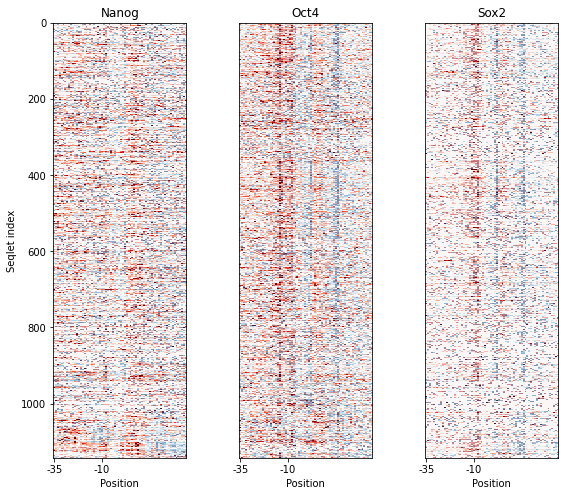

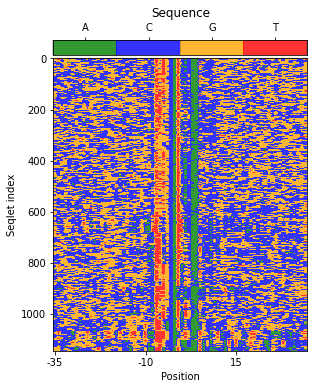

In [39]:
sc.plot(kind='profile_agg', figsize_tmpl=(3.3, 2));
sc.plot(kind='profile', figsize=(10, 8));
sc.plot(kind='seq',figsize_tmpl=(13, 10));
plt.title("Sequence");
# sc.plot(kind='contrib', figsize=(10, 8));

## Generating further reports

For analyzing ChIP-nexus/exo/seq data, there exist an additional report generated by `bpnet chip-nexus analysis` after running modisco.

In [40]:
# generate more extensive reports specific for ChIP-nexus/exo data
# We'll use a slightly smaller footprint width since the seqlets may run out of chromosomes instead
!bpnet chip-nexus-analysis {modisco_dir}/Oct4 --footprint-width=150

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

In [41]:
# This prouced new files to the output directory
!ls -latr {modisco_dir}/Oct4/

合計 33316
drwxr-xr-x 3 dahale.onkar mib-dbia     4096  4月 24 18:10 ..
-rw-r--r-- 1 dahale.onkar mib-dbia      656  4月 24 18:10 modisco-run.kwargs.json
-rw-r--r-- 1 dahale.onkar mib-dbia      186  4月 24 18:10 modisco-run.config.gin
-rw-r--r-- 1 dahale.onkar mib-dbia        4  4月 24 18:10 modisco-run.config.gin.json
-rw-r--r-- 1 dahale.onkar mib-dbia    19773  4月 24 18:10 modisco-run.subset-contrib-file.npy
-rw-r--r-- 1 dahale.onkar mib-dbia 16257056  4月 24 18:13 modisco.h5
-rw-r--r-- 1 dahale.onkar mib-dbia    69697  4月 24 18:13 modisco.ipynb
-rw-r--r-- 1 dahale.onkar mib-dbia   643414  4月 24 18:13 modisco.html
drwxr-xr-x 4 dahale.onkar mib-dbia     4096  4月 24 18:15 plots
-rw-r--r-- 1 dahale.onkar mib-dbia   461824  4月 24 18:15 modisco-chip.ipynb
-rw-r--r-- 1 dahale.onkar mib-dbia   790762  4月 24 18:15 modisco-chip.html
drwxr-xr-x 4 dahale.onkar mib-dbia     4096  4月 24 18:15 seqlets
-rw-r--r-- 1 dahale.onkar mib-dbia 15584187  4月 24 18:15 patterns.pkl
drwxr-xr-x 2 dahale.onkar mib-dbia


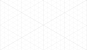
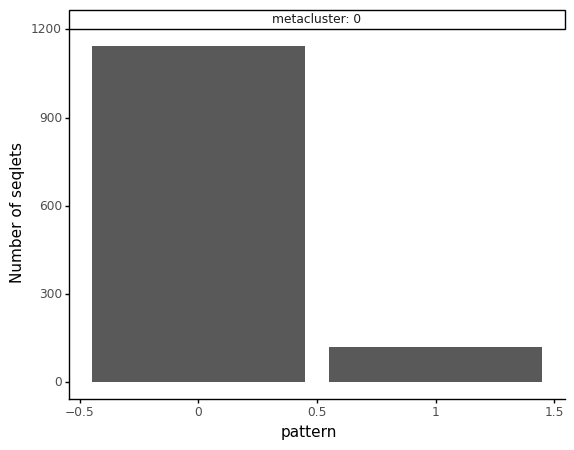
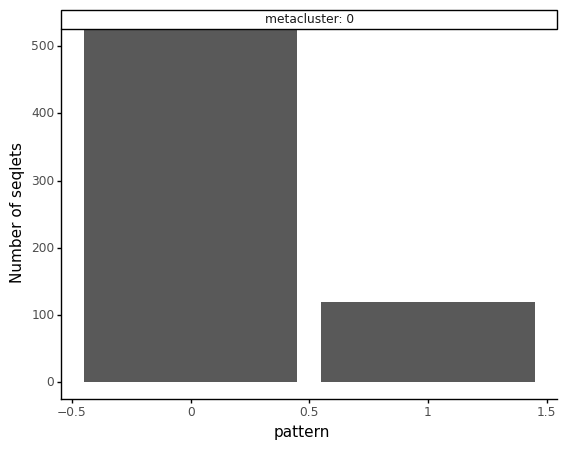
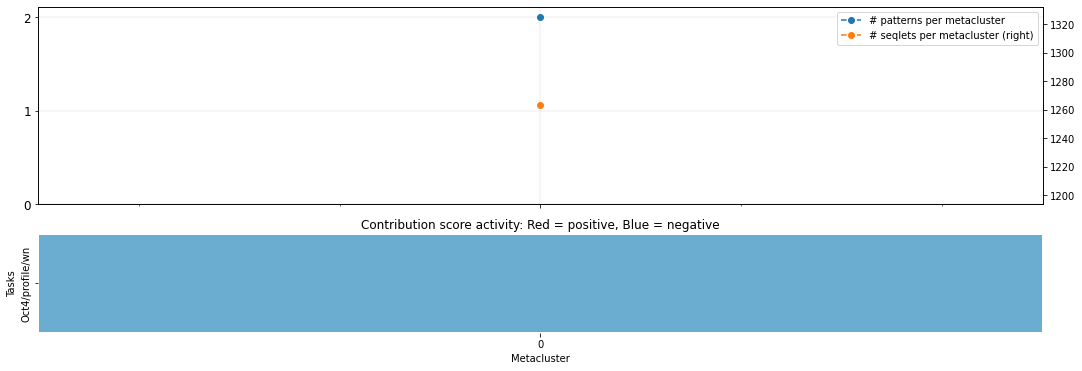
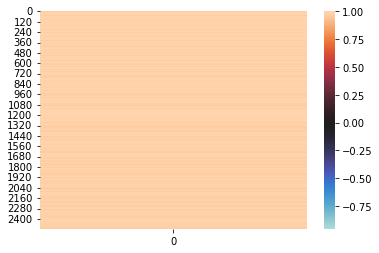

In [43]:
# NOTE: the heatmap files will not be displayed here since
# the file paths of the plots are not correct.
HTML(f"{modisco_dir}/Oct4/modisco-chip.html")

## Running modisco for the remaining tasks

Next, we will run modisco on the contribution scores for the remaining tasks: Sox2 and Nanog.

In [44]:
tasks = ['Oct4', 'Sox2', 'Nanog']

In [45]:
# Run modisco only for the Nanog task
for task in tasks:
  if task == 'Oct4':
    # already exists from before
    continue
  print(f"task: {task}")
  !bpnet modisco-run {contrib_file} --null-contrib-file={contrib_null_file} --override='TfModiscoWorkflow.min_metacluster_size = 1000' --contrib-wildcard={task}/profile/wn --only-task-regions --premade=modisco-50k {modisco_dir}/{task}/ --overwrite

task: Sox2
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/

### Visualizing the results

You can now use `MultipleModiscoResult` class to handle multiple `ModiscoResult` objects and visualize motifs discovered in all the tasks.

In [47]:
# MultipleModiscoResult is a convenience wrapper around ModiscoResult
mf = ModiscoFileGroup({t: ModiscoFile(Path(modisco_dir) / t / 'modisco.h5') for t in tasks})

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


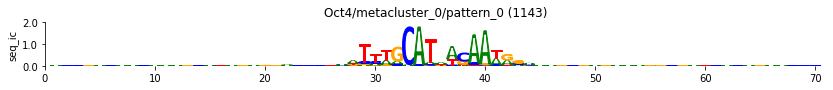

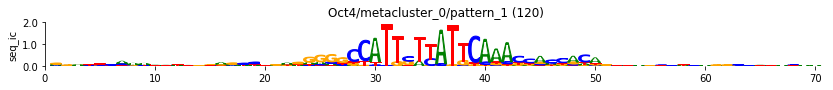

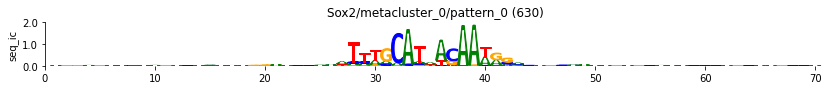

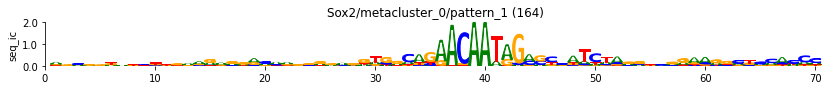

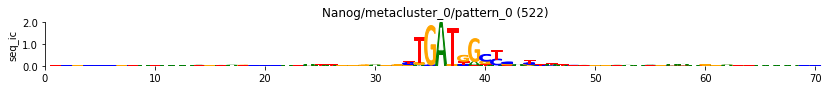

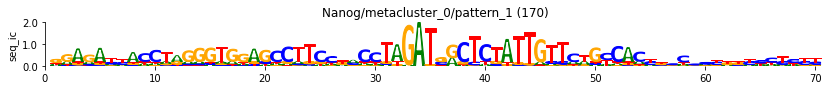

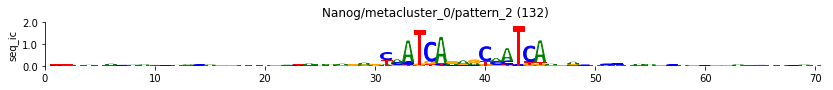

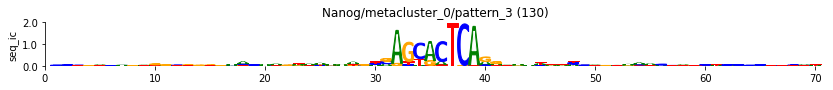

In [48]:
# Plot all the patterns
for p in mf.patterns():
  p.plot("seq_ic", title=f"{p.name} ({mf.n_seqlets(p.name)})")
  plt.ylim([0, 2])
  sns.despine(top=True, bottom=True, right=True)

# Get motif instances with CWM scanning

To get motif instances in the genome, we will use CWM scanning using the `bpnet cwm-scan` command.

In [49]:
!bpnet cwm-scan -h

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

We will run CWM scanning across the regions of all peaks, not just peaks of the TF for which TF-MoDISco was ran.

In [57]:
# run CWM scanning for each task
for task in tasks:
  !bpnet cwm-scan {modisco_dir}/{task} {modisco_dir}/{task}/motif-instances.tsv.gz --contrib-file {contrib_file} --add-profile-features

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/

In [58]:
# Let's load the resulting table:
dfi = pd.read_csv(Path(modisco_dir) / 'Nanog/motif-instances.tsv.gz', sep='\t')

In [59]:
dfi.head()

,example_chrom,pattern_start_abs,pattern_end_abs,pattern,contrib_weighted_p,strand,match_weighted_p,example_idx,pattern_start,pattern_end,...,Sox2/profile_counts_p,Sox2/profile_max,Sox2/profile_max_p,Sox2/profile_counts_max_ref,Sox2/profile_counts_max_ref_p,pattern_short,example_start,example_end,example_strand,example_interval_from_task
0,chr17,35504067,35504079,metacluster_0/pattern_0,0.846154,+,0.698077,1,115,127,...,0.998084,37.000000,1.000000,6.000002,0.973180,m0_p0,35503952,35504152,.,Oct4
1,chr17,48616442,48616454,metacluster_0/pattern_0,0.821154,-,0.915385,9,103,115,...,0.994253,85.000000,1.000000,7.000002,0.977011,m0_p0,48616339,48616539,.,Oct4
2,chr16,78265400,78265412,metacluster_0/pattern_0,0.011538,+,0.350000,37,96,108,...,0.990421,15.000001,0.982759,13.000002,0.998084,m0_p0,78265304,78265504,.,Oct4
3,chr2,68819277,68819289,metacluster_0/pattern_0,0.051923,-,0.213462,56,110,122,...,0.622605,2.000001,0.559387,0.000002,0.814176,m0_p0,68819167,68819367,.,Oct4
4,chr18,23993816,23993828,metacluster_0/pattern_0,0.017308,+,0.388462,70,117,129,...,0.934866,7.000001,0.929119,0.000002,0.814176,m0_p0,23993699,23993899,.,Oct4


### Column description of motif instance table a.k.a. `dfi`

First seven columns are the most important ones. These represent the motif instance coordinates and the two scores derived from CWM scanning (contribution and match scores):
- chrom
- start
- end
- pattern name
- contribution score ([0, 1], 1 = highest contribution, 0=lowest contribution)
- strand.
- CWM match score measuring the Jaccard similarity between CWM and the contribution scores ([0, 1], 1 = excellent match, 0=poor match)


Here is the full column name description:

***Motif instance position***
- `example_chrom` - chromosome name
- `pattern_start_abs` - chromosome start position (0-based, same as BED files)
- `pattern_end_abs` - chromosome end position (0-based, same as BED files)
- `pattern_len` - pattern length (same as `pattern_end_abs - pattern_start_abs`)
- `pattern` - pattern name from TF-MoDISco (e.g. `metacluster_0/pattern_1`)
- `pattern_short` - short pattern name from TF-MoDISco (e.g. `m0_p1`)
- `strand` - strand of the motif instance match
- `id` - unique ID for each motif instance (row number of the original pd.DataFrame)

***Scanned region information***
- `example_idx` - index of the scanned region. This corresponds to the item in the scanned `ContribFile`.
- `example_start` - start position of the scanned region.
- `example_end` - end of the scanned region.
- `example_strand` - strand of the scanned region
- `example_interval_from_task` - `task` for which the scanned region was derived (e.g. Oct4 means that that region was an Oct4 peak specified in `dataspec.yml`).

***Relative motif region information***
- `pattern_start` - start position within the region
- `pattern_end` - end position within the regions
- `pattern_center` - center position within the regions

***PWM scan match***
- `seq_match` - classical PWM match score

***Contribution score amount***
- `contrib/{task}` - Absolute amount of the contribution score for task `{task}` at the motif instance position.
- `contrib_max` - maximum match value across all `contrib/{task}` columns
- `contrib_max_task` - task name for which `contrib/{task}` is maximal
- `contrib_weighted` - contribution score weighted across tasks. ***NOTE*** If only a single task was used to run modisco as it is the case in this tutorial, then `contrib/{task} = contrib_max = contrib_weighted`.
- `contrib_weighted_cat` - contribution score category (low, medium, high). These were determined by partitioning contrib_weighted_p according to the intervals (0, 0.33], (0.33, 0.66], (0.66, 1]

***CWM match***
- `match/{task}` - Jaccard similarity between the contribution score for task `{task}` and the CWM
- `match_max` - maximum match value across all `match/{task}` columns
- `match_max_task` - task name for which `match/{task}` is maximal
- `match_weighted` - contribution score weighted across tasks.  ***NOTE*** If only a single task was used to run modisco as it is the case in this tutorial, then `match/{task} = match_max = match_weighted`.
- `match_weighted_cat` - contribution score quantile

***Footprint evaluation (optional)***
- `{task}/profile_max` - maximal number of footprint count in the 70 bp window at the motif instance
- `{task}/profile_counts_max_ref` - number of counts at the position where the reference footprint is maximal (sum across strands).
- `{task}/profile_match` - symmetric KL divergence between the original footprint and the observed footprint (footprint = 70 bp wide)
- `{task}/profile_counts` - total number of counts of `{task}` in the 70 bp window at the motif instance


***NOTE***: All the columns ending with ***`_p`*** contain the CDF values (value between 0 and 1) using the original TF-MoDISco seqlets to determine the distribution.

See the `bpnet.modisco.pattern_instances` module for more function to interact with that table. Throughout the whole codebase, that table is refered to as `dfi` (**d**ata-***f***rame of ***i***nstances).

## Locus visualization with motif instances higlighted

Let's visualize the same region as above, but this time highlighting differnet motif instances.

In [60]:
from bpnet.utils import pd_col_prepend
from bpnet.modisco.pattern_instances import dfi2seqlets
from bpnet.modisco.utils import shorten_pattern, longer_pattern

In [61]:
# First load all the motif instances simultaneously
dfi = pd.concat([pd.read_csv(Path(modisco_dir) / f'{task}/motif-instances.tsv.gz', sep='\t').
                 assign(tf=task).
                 pipe(pd_col_prepend, ['pattern', 'pattern_short'], prefix=task + "/")  # prefix the pattern names with task name
                 for task in tasks], sort=False)

2024-04-24 18:44:40,591 [INFO] Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-04-24 18:44:40,592 [INFO] NumExpr defaulting to 8 threads.


In [62]:
idx = 1  # we'll use the same idx as displayed before

# pattern instances in that locus
dfi[dfi.example_idx == idx]

# note that some instances have a poor match (match_weighted_p low)

,example_chrom,pattern_start_abs,pattern_end_abs,pattern,contrib_weighted_p,strand,match_weighted_p,example_idx,pattern_start,pattern_end,...,pattern_short,example_start,example_end,example_strand,example_interval_from_task,tf,match/Sox2,contrib/Sox2,match/Nanog,contrib/Nanog
2,chr17,35504048,35504064,Oct4/metacluster_0/pattern_0,0.972807,+,0.785965,1,96,112,...,Oct4/m0_p0,35503952,35504152,.,Oct4,Oct4,NaN,NaN,NaN,NaN
2936,chr17,35504041,35504085,Oct4/metacluster_0/pattern_1,1.000000,-,0.333333,1,89,133,...,Oct4/m0_p1,35503952,35504152,.,Oct4,Oct4,NaN,NaN,NaN,NaN
2,chr17,35504048,35504064,Sox2/metacluster_0/pattern_0,0.992038,+,0.783439,1,96,112,...,Sox2/m0_p0,35503952,35504152,.,Oct4,Sox2,0.503787,1.817735,NaN,NaN
2257,chr17,35504026,35504091,Sox2/metacluster_0/pattern_1,0.993377,+,0.364238,1,74,139,...,Sox2/m0_p1,35503952,35504152,.,Oct4,Sox2,0.275295,2.905424,NaN,NaN
0,chr17,35504067,35504079,Nanog/metacluster_0/pattern_0,0.846154,+,0.698077,1,115,127,...,Nanog/m0_p0,35503952,35504152,.,Oct4,Nanog,NaN,NaN,0.586048,1.489516
5718,chr17,35504059,35504090,Nanog/metacluster_0/pattern_3,0.868217,-,0.604651,1,107,138,...,Nanog/m0_p3,35503952,35504152,.,Oct4,Nanog,NaN,NaN,0.344905,2.036840


In [63]:
# convert dfi to Seqlet objects
seqlets = [s.shift(-xrange.start)
           for s in dfi2seqlets(dfi[dfi.example_idx == idx], short_name=True)]
seqlets

# # let's visualize these patterns
# mf = ModiscoFileGroup({t: ModiscoFile(modisco_dir / f'{t}/modisco.h5') for t in tasks})
# observed_patterns = {s.name for s in seqlets}  # get unique pattern names

# for pn in observed_patterns:
#   # NOTE: modisco requires the longer pattern version (e.g. {Task}/metacluster_0/pattern_1)
#   pn_long = longer_pattern(pn)
#   mf.get_pattern(pn_long).trim_seq_ic(0.08).plot('seq_ic')
#   sns.despine(top=True, bottom=True, right=True)

[Seqlet(seqname=1, start=46, end=62, name='Oct4/m0_p0', strand='+'),
 Seqlet(seqname=1, start=39, end=83, name='Oct4/m0_p1', strand='-'),
 Seqlet(seqname=1, start=46, end=62, name='Sox2/m0_p0', strand='+'),
 Seqlet(seqname=1, start=24, end=89, name='Sox2/m0_p1', strand='+'),
 Seqlet(seqname=1, start=65, end=77, name='Nanog/m0_p0', strand='+'),
 Seqlet(seqname=1, start=57, end=88, name='Nanog/m0_p3', strand='-')]

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


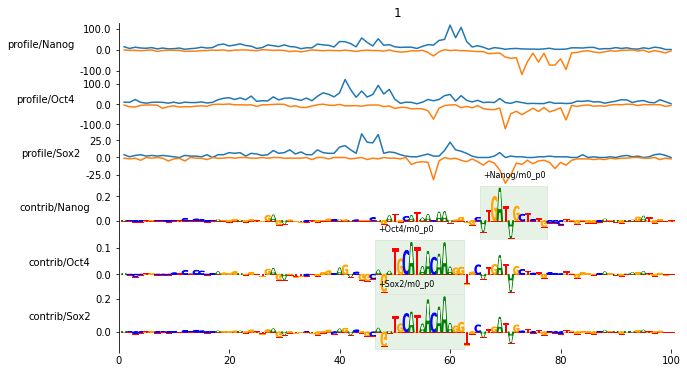

In [64]:
# Visualize the locus with motif instances highlighted

# get the contribution scores and profile score for that example idx
xrange = slice(50, 150)
cf = ContribFile(contrib_file)
profiles = cf.get_profiles(idx=idx)
contrib_scores = cf.get_contrib(idx=idx)


# Let's focus only on the best match per track
dfi_best = dfi[dfi.example_idx == idx].sort_values("match_weighted_p", ascending=False).groupby('tf').first()

seqlets = [s.shift(-xrange.start)
           for s in dfi2seqlets(dfi_best, short_name=True)]


plot_tracks({**{'profile/' + k: to_neg(v[xrange]) for k,v in profiles.items()},
             **{'contrib/' + k:v[xrange] for k,v in contrib_scores.items()}},
           title=idx,
           rotate_y=0,
           fig_width=10,
           seqlets=[s.set_seqname('contrib/' + s.name.split("/")[0]) for s in seqlets], # plot seqlets to the 'contrib/Nanog' track
           fig_height_per_track=1);
sns.despine(top=True, right=True, bottom=True)

## ChIP-nexus heatmap visualization

/mnt/mib-nas03_1/users/dahale.onkar/bpnet/bpnet/plot/heatmaps.py:40: RuntimeWarning: invalid value encountered in true_divide
  snorms = np.minimum(s / p99[:, np.newaxis], 1)


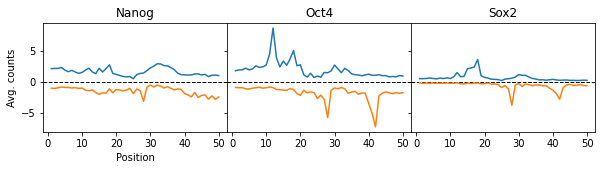

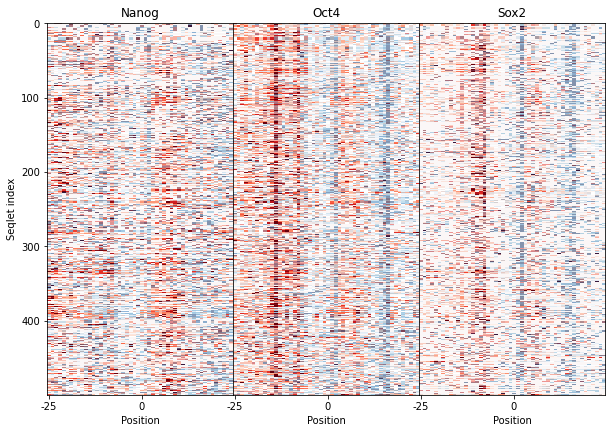

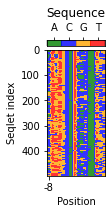

In [66]:
# get the chip-nexus data at the best motif isntances
dfi = pd.read_csv(Path(modisco_dir) / 'Oct4/motif-instances.tsv.gz', sep='\t')

cf = ContribFile(contrib_file)

# extract into `StackedSeqletContrib`
sc = cf.extract_dfi(dfi.
                    query("pattern_short == 'm0_p0'").
                    sort_values('contrib_weighted_p', ascending=False).iloc[:500],
                    profile_width=50)

sc.plot(kind='profile_agg', figsize_tmpl=(3.3, 2));
sc.plot(kind='profile', figsize=(10, 8));
sc.plot(kind='seq',figsize_tmpl=(13, 10));
plt.title("Sequence");
# sc.plot(kind='contrib', figsize=(10, 8));

## De-novo sequence scanning

Say we would like to determine motif instances in a new sequence. Here is how to do that.

In [110]:
# Load the SeqModel
from bpnet.seqmodel import SeqModel
# In case you get `Can't get attribute '_make_skeleton_class'` error, please restart the runtime
# Runtime -> Reset runtimeb -> Yes
seq_path = "/home/dahale.onkar/bpnet/examples/chip-nexus/output/2024-04-24_17-55-09_8f87171d-edeb-4b78-b5d8-d65bea20f49a/"
sm = SeqModel.from_mdir(Path(seq_path))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2024-04-24 19:09:24,889 [WARNING] From /home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2024-04-24 19:09:30,627 [WARNING] From /home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [111]:
from bpnet.plot.tracks import filter_tracks, plot_tracks
from concise.preprocessing import encodeDNA
from collections import OrderedDict

# Core of the Oct4 enhancer sequence
seq = 'N'*23 + 'GGAGGAACTGGGTGTGGGGAGGTTGTAGCCCGACCCTGCCCCTCCCCCCAGGGAGGTTGAGAGTTCTGGGCAGACGGCAGATGCATAACAAAGGTGCATGATAGCTCTGCCCTGGGGGCAGAGAAGATGGTTGGGGAGGGGTCCCTCTCGTCCTA' + 'N'*22
seq_onehot = encodeDNA([seq]) # one-hot encode


# Compute contribution scores
contrib_scores = sm.contrib_score_all(seq_onehot, preact_only=True)
contrib_scores = [(f'Contrib {k}', seq_onehot[0] * v[0])
                  for k,v in contrib_scores.items()
                  if k.endswith("profile/wn")]  # keep only */profile/wn scores

# Make predictions
preds = sm.predict(seq_onehot)
preds = [(f"Pred {task}", to_neg(preds[f"{task}/profile"][0]) * np.exp(preds[f"{task}/counts"][0]))
         for task in sm.tasks]  # merge predictions

viz_dict = OrderedDict(preds + contrib_scores)

xlim = [50, 180]  # Focus only on the central
viz_dict = filter_tracks(viz_dict, xlim)

Instructions for updating:
dim is deprecated, use axis instead


2024-04-24 19:09:57,438 [WARNING] From /mnt/mib-nas03_1/users/dahale.onkar/bpnet/bpnet/heads.py:318: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


In [114]:
# determine the location of the first instance
from bpnet.modisco.files import ModiscoFile

mf = ModiscoFile(Path(modisco_dir) / 'Oct4/modisco.h5')
pattern = mf.get_pattern("metacluster_0/pattern_0").trim_seq_ic(0.08)  # get trimmed pattern
task = 'Oct4'

# scan the contribution scores + DNA sequence
match, contribution = pattern.scan_contribution({task: dict(contrib_scores)[f'Contrib {task}/profile/wn'][np.newaxis]},
                                                 hyp_contrib=None, tasks=[task], n_jobs=1, verbose=False)
seq_match = pattern.scan_seq(seq_onehot, n_jobs=1, verbose=False)

# load the normalization table
dfi_norm = pd.read_csv(f"{modisco_dir}/{task}/cwm-scan-seqlets.trim-frac=0.08.csv.gz")

# get the motif instance table
dfm = pattern.get_instances([task], match, contribution, seq_match,
                            norm_df=dfi_norm[dfi_norm.pattern == pattern.name],
                            verbose=False, plot=False)
dfm

,pattern,example_idx,pattern_start,pattern_end,strand,pattern_center,pattern_len,match_weighted,match_weighted_p,match_weighted_cat,...,contrib_weighted,contrib_weighted_p,contrib_weighted_cat,contrib_max,contrib_max_task,seq_match,seq_match_p,seq_match_cat,match/Oct4,contrib/Oct4
0,metacluster_0/pattern_0,0,101,117,+,109,16,0.45279,0.566667,medium,...,1.007893,0.970175,high,1.007893,Oct4,11.186763,0.774561,high,0.45279,1.007893


/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


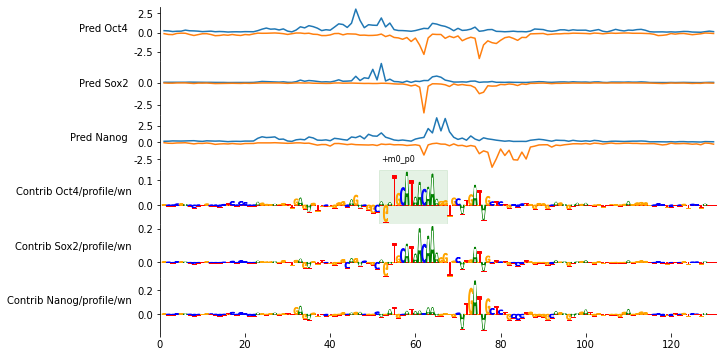

In [115]:
# convert dfi to Seqlet objects and plot it
from bpnet.modisco.pattern_instances import dfi2seqlets

seqlets = [s.shift(-xlim[0]).set_seqname(f'Contrib {task}/profile/wn')
         for s in dfi2seqlets(dfm, short_name=True)]

plot_tracks(viz_dict,
            fig_height_per_track=1,
            fig_width=10,
            seqlets=seqlets,
            rotate_y=0);
sns.despine(top=True, right=True, bottom=True)

## Motif spacing visualization

Here, we will visualize the motif spacing between the two Nanog motifs

/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


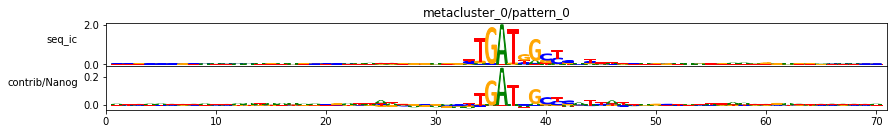

In [117]:
from bpnet.modisco.files import ModiscoFile

# Let's load the resulting table:
dfi = pd.read_csv(Path(modisco_dir) / 'Nanog/motif-instances.tsv.gz', sep='\t')
# visualize spacing for Nanog/metacluster_0/pattern_0
mf = ModiscoFile(Path(modisco_dir) / 'Nanog/modisco.h5')
p = mf.get_pattern('metacluster_0/pattern_0')
p.plot(['seq_ic', "contrib"], rotate_y=0);

In [118]:
# create a table of motif_paris
from bpnet.modisco.pattern_instances import motif_pair_dfi  # main function for motif spacing


dfi_subset = dfi[dfi.pattern == p.name]  # use only the first pattern
dfi_subset['pattern_name'] = 'Nanog'  # motif_pair_dfi requires `pattern_name` column

dfab = motif_pair_dfi(dfi_subset, ['Nanog', 'Nanog'])
print(len(dfab))
dfab.head()

329


/home/dahale.onkar/anaconda3/envs/bpnet/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,example_chrom_x,pattern_start_abs_x,pattern_end_abs_x,pattern_x,contrib_weighted_p_x,strand_x,match_weighted_p_x,example_idx,pattern_start_x,pattern_end_x,...,Sox2/profile_counts_max_ref_y,Sox2/profile_counts_max_ref_p_y,pattern_short_y,example_start_y,example_end_y,example_strand_y,example_interval_from_task_y,pattern_name_y,center_diff,strand_combination
31,chr18,46914536,46914548,metacluster_0/pattern_0,0.905769,-,0.746154,261,88,100,...,8.000002,0.984674,m0_p0,46914448,46914648,.,Oct4,Nanog,26,-+
48,chr19,23095063,23095075,metacluster_0/pattern_0,0.711538,+,0.515385,332,70,82,...,8.000002,0.984674,m0_p0,23094993,23095193,.,Oct4,Nanog,26,+-
63,chr17,84355211,84355223,metacluster_0/pattern_0,0.332692,-,0.455769,390,80,92,...,10.000002,0.988506,m0_p0,84355131,84355331,.,Oct4,Nanog,12,++
85,chr16,12961012,12961024,metacluster_0/pattern_0,0.440385,+,0.315385,566,70,82,...,1.000002,0.814176,m0_p0,12960942,12961142,.,Oct4,Nanog,9,++
94,chr18,38593030,38593042,metacluster_0/pattern_0,0.686538,-,0.513462,604,94,106,...,0.000002,0.814176,m0_p0,38592936,38593136,.,Oct4,Nanog,10,++


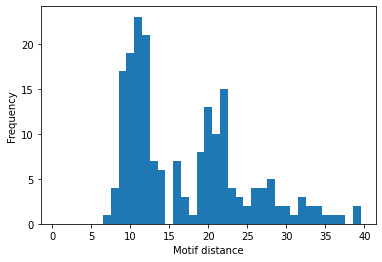

In [119]:
plt.hist(dfab[dfab.strand_combination == "++"].center_diff, bins=np.arange(40)+0.5)
plt.xlabel("Motif distance")
plt.ylabel("Frequency");

## FAQ

### How do I score new regions not present in  the contribution file?


If you would like to get motif instances for regions not present in the contribution file, the easiest is to first generate the contribution file for your regions of interest using `bpnet contrib ... --regions=regions.bed`  and then run `cwm-scan` with `--contrib-file` pointing to this new contribution file.

# Simulate motif spacing


Showcase the `BPNet` model API
    - visualize the locus with contrib scores + predictions
    - motif spacing + simulation

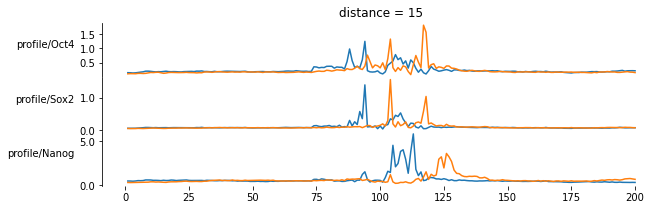

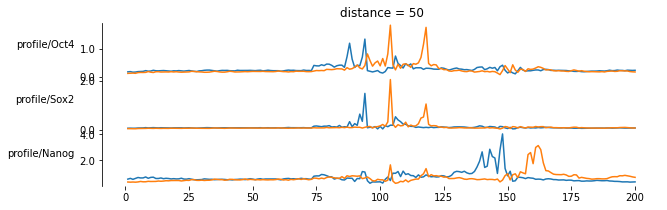

In [120]:
# Simulate Oct4-Sox2 and Nanog spacing
from bpnet.BPNet import BPNetSeqModel

bpn = BPNetSeqModel(sm)  # wrap SeqModel to BPNetSeqModel to get `sim_pred` method


plot_tracks(bpn.sim_pred(central_motif='TTTGCATAACAA', side_motif='AGCCATCA', side_distances=[115]),
            fig_height_per_track=1,
            fig_width=10,
            rotate_y=0,
            title="distance = 15");
sns.despine(top=True, right=True, bottom=True)


plot_tracks(bpn.sim_pred(central_motif='TTTGCATAACAA', side_motif='AGCCATCA', side_distances=[150]),
            fig_height_per_track=1,
            fig_width=10,
            rotate_y=0,
            title='distance = 50');
sns.despine(top=True, right=True, bottom=True)

In [121]:
# run simulation for the whole range
# quantify the profile height (profile/* features)
from bpnet.simulate import generate_sim

res = generate_sim(bpn, central_motif='AGCCATCA', side_motif='TTTGCATAACAA', side_distances=np.arange(110, 170), center_coords=[65, 135], contribution=[], correct=True)

dfs, profiles = res
dfs.head()

100%|██████████| 60/60 [00:08<00:00,  7.02it/s]


,profile/simmetric_kl,profile/counts,profile/counts_frac,profile/max,profile/max_frac,profile/counts_max_ref,profile/counts_max_ref_frac,task,central_motif,side_motif,position,distance
0,inf,29.613268,1.048945,0.945915,2.400693,1.411735,1.881405,Oct4,AGCCATCA,TTTGCATAACAA,110,10
1,inf,14.896339,1.102962,1.278037,7.719415,0.330039,1.025569,Sox2,AGCCATCA,TTTGCATAACAA,110,10
2,inf,92.351822,1.074406,3.418550,1.138387,5.272453,1.002193,Nanog,AGCCATCA,TTTGCATAACAA,110,10
3,inf,28.340651,1.003867,0.956761,2.428217,1.689463,2.251531,Oct4,AGCCATCA,TTTGCATAACAA,111,11
4,inf,13.100884,0.970022,0.242171,1.462725,0.435741,1.354029,Sox2,AGCCATCA,TTTGCATAACAA,111,11


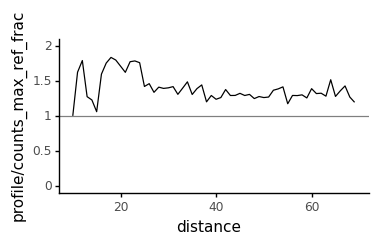

<ggplot: (-9223363248561493679)>

In [122]:
from plotnine import *
import plotnine

plotnine.options.figure_size = (4, 2)
(ggplot(aes(x='distance', y='profile/counts_max_ref_frac'), dfs[dfs.task=='Nanog']) +
 geom_line() +
 geom_hline(yintercept=1, alpha=0.5) +
 ylim([0, 2]) +
 theme_classic())

# FAQ

### I want to train a model on ChIP-seq. How can I do this?

Follow the same procedure as for ChIP-nexus.

### I want to train a model on DNase-seq or ATAC-seq. How can I do this?

The key difference between DNase-seq and ChIP-seq/exo is that DNase-seq coverage is not strand specific. Hence a single BigWig file is required. By contrast, ChIP-seq required two BigWigs - one for the positive and one for the negative strand. Beware that controlling for DNase biases is still an open question and you should think carefully about it.

Otherwise, you can just specify a similar `dataspec.yml` as before:

# Notes / Ideas

- Allow the user to download the output files instead of running the model by adding an if else in each chapter
  - e.g. make each chapter independent of each other
  - required files:
    - contrib: `seq_model.pkl`, `config.gin.json`, `dataspec.yml`
    - modisco-run: `contrib_file`, `null_contrib_file`
    - cwm-scan: `modisco.h5`, `modisco-run.subset-contrib-file.npy`, `modisco-run.kwargs.json`
    - reports: ...?
- bpnet
- [ ] go through all the paper notebooks and list useful things to show
  - how do I visualize a particular locus with all the motif instances + contrib scores?
- [ ] shall we rename `example->regions` in dfi?

In [ ]:
# Export the generated files

# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# bpnet_demo_dir = '/gdrive/My\ Drive/projects/chipnexus/data/bpnet-demo'
# !mkdir -p {bpnet_demo_dir}
# !cp -R {model_dir} {bpnet_demo_dir}/